In [ ]:
# Parte 1: Efectos de tratamientos heterogéneos utilizando árboles y bosques causales



In [1]:
# En primer lugar, cargamos la data experimental  para calcular efectos heterogéneos a través de árboles y bosques causales.
df <- read.csv("C:/Users/USER/Desktop/github/CausalAI-Course/Labs/Assignment/Assignment_5/data/experimental/experimental_control.csv")
head(df)

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0459
2,1,22,9,0,1,0,1,0,0,3595.8940
3,1,30,12,1,0,0,0,0,0,24909.4492
4,1,27,11,1,0,0,1,0,0,7506.1460
5,1,33,8,1,0,0,1,0,0,289.7899
6,1,22,9,1,0,0,1,0,0,4056.4939


In [2]:
# En segundo lugar hallamos el ATE, para ello usamos la variable re78 y la diferencia entre las medias del grupo de tratamiento y el grupo de control
model <- lm(re78 ~ treat, data = df)
summary(model)$coefficients



,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4554.801,408.0459,11.162474,1.154114e-25
treat,1794.342,632.8534,2.835321,4.787530e-03


In [ ]:
#interpretacion

In [3]:
#En tercer lugar , construimos nuestra variable auxiliar y ajustamos un regresor de árbol de decisión.
X <- setdiff(names(df), c("treat", "re78"))
X

[1] "age"      "educ"     "black"    "hisp"     "marr"     "nodegree" "re74"    
[8] "re75"

Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpcX5dQT\downloaded_packages


Warning message:
"package 'ggplot2' was built under R version 4.4.2"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


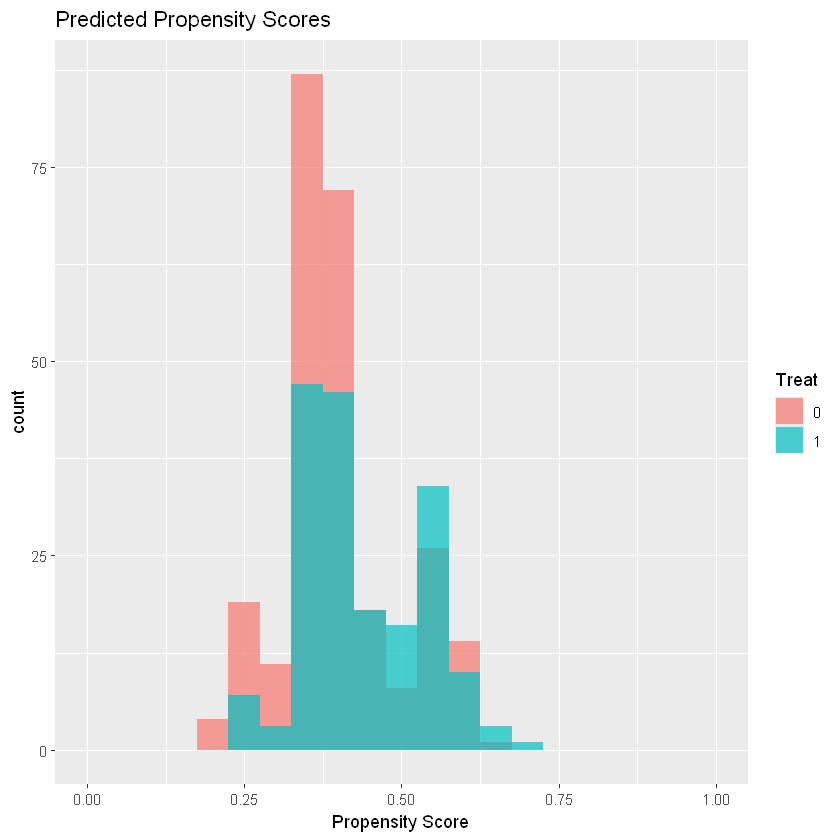

In [5]:
logistic_model <- glm(treat ~ ., data = df[, c(X, 'treat')], family = binomial)
df$pscore <- predict(logistic_model, df[X], type = "response")
install.packages("ggplot2") 
library(ggplot2)
ggplot(df, aes(x = pscore, fill = as.factor(treat))) +
  geom_histogram(binwidth = 0.05, position = "identity", alpha = 0.7) +
  labs(
    title = "Predicted Propensity Scores",
    x = "Propensity Score",
    fill = "Treat"
  ) +
  xlim(0, 1)

     

In [7]:

df$y_star <- df$re78 / (df$pscore - (1 - df$pscore))

# Ahora calculas la media de la nueva columna 'y_star'
mean(df$y_star, na.rm = TRUE)


head(df)


[1] -9477.057

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,pscore,y_star
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0459,0.4021026,-50716.601
2,1,22,9,0,1,0,1,0,0,3595.8940,0.2466787,-7097.497
3,1,30,12,1,0,0,0,0,0,24909.4492,0.5594795,209395.395
4,1,27,11,1,0,0,1,0,0,7506.1460,0.3526728,-25474.413
5,1,33,8,1,0,0,1,0,0,289.7899,0.4096518,-1603.739
6,1,22,9,1,0,0,1,0,0,4056.4939,0.3802885,-16942.797


In [8]:
X <- df[,X] 
Y <- df[,"re78"]
D <- df[,"treat"]

In [9]:
library(grf)
tree <- causal_forest(X, Y, D, num.trees = 1, mtry = ncol(X))
get_tree(tree, 1)

Warning message:
"package 'grf' was built under R version 4.4.2"


GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 21 
  (2) split_variable: age  split_value: 19 
    (4) * num_samples: 32  avg_Y: 5355.09 avg_W: 0.47 
    (5) * num_samples: 6  avg_Y: 8410.87 avg_W: 0.5 
  (3) split_variable: educ  split_value: 10 
    (6) split_variable: educ  split_value: 8 
      (8) * num_samples: 6  avg_Y: 1661.42 avg_W: 0.5 
      (9) split_variable: age  split_value: 25 
        (12) * num_samples: 10  avg_Y: 1007.36 avg_W: 0.4 
        (13) * num_samples: 11  avg_Y: 10582.23 avg_W: 0.36 
    (7) split_variable: marr  split_value: 0 
      (10) split_variable: age  split_value: 29 
        (14) * num_samples: 24  avg_Y: 5346.7 avg_W: 0.46 
        (15) * num_samples: 12  avg_Y: 3778.65 avg_W: 0.25 
      (11) * num_samples: 10  avg_Y: 3625.02 avg_W: 0.5 

In [10]:
#Las personas jóvenes (menores de 21 años) tienden a tener un promedio de Y más alto si tienen más de 19 años. Por otro lado, las personas menores de 19 años tienden a tener un promedio de Y más bajo.
#Para personas mayores de 21 años, la variable educ (años de educación) se convierte en un factor importante.
#La educación parece estar relacionada con un mayor ingreso o puntuación de Y, aunque la relación no es siempre consistente. Por ejemplo, en el grupo con menos de 8 años de educación, los ingresos promedio son bajos.
#Las personas casadas (marr = 1) tienden a tener un promedio de Y algo más bajo que las solteras (marr = 0), especialmente en los grupos con mayor educación.
#el árbol de decisión ha encontrado que la edad y la educación son factores importantes para predecir el valor de Y, y el estado civil (marr) tiene un impacto adicional en los grupos más educados. Las personas más jóvenes y educadas tienden a tener mayores valores en Y, mientras que las personas casadas o con menos educación tienden a tener valores más bajos.

In [11]:
#En cuarto lugar, vamos a ajustar un regresor de bosque aleatorio, para explicar los efectos heterogeneos
cf <- causal_forest(X, Y, D)
tree <- get_tree(cf, 1)
tree

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 20 
  (2) * num_samples: 25  avg_Y: 4783.72 avg_W: 0.2 
  (3) split_variable: re75  split_value: 863.479 
    (4) split_variable: nodegree  split_value: 0 
      (6) * num_samples: 18  avg_Y: 8052.32 avg_W: 0.56 
      (7) split_variable: age  split_value: 27 
        (8) * num_samples: 28  avg_Y: 3711.31 avg_W: 0.25 
        (9) * num_samples: 16  avg_Y: 3201.24 avg_W: 0.31 
    (5) * num_samples: 24  avg_Y: 6810.06 avg_W: 0.46 

In [12]:
varimp <- variable_importance(cf)
ranked.vars <- order(varimp, decreasing = TRUE)
importances <- data.frame(variable = colnames(X)[ranked.vars], importance = varimp[ranked.vars])
importances

variable,importance
<chr>,<dbl>
age,0.309894023
re74,0.209354546
educ,0.173191332
re75,0.160908223
marr,0.065641863
nodegree,0.054979589
black,0.024976238
hisp,0.001054186


In [13]:
#Por ultimo,  Graficar cómo cambia el efecto del tratamiento previsto en función de una variable de su elección.


#Aislamos efectos predichos por variable
df$predicted_effects <- predict(cf, X)$predictions
  
# Modificamos variable age en intervalos de 5
df$age_bins <- floor(df$age / 5) * 5
# Modificamos variable re74 en intervalos de 500 porque es continua
df$age_bins[df$age_bins < 15] <- 15  # Reemplazamos por el valor mínimo de la variable
predicted_effects_age <- aggregate(predicted_effects ~ age_bins, data = df, mean)

df$re74_bins <- floor(df$re74 / 500) * 500  

# Modificamos variable re75 en intervalos de 500 porque es continua
predicted_effects_re74 <- aggregate(predicted_effects ~ re74_bins, data = df, mean)

predicted_effects_educ <- aggregate(predicted_effects ~ educ, data = df, mean)

df$re75_bins <- floor(df$re75 / 500) * 500  
predicted_effects_re75 <- aggregate(predicted_effects ~ re75_bins, data = df, mean)

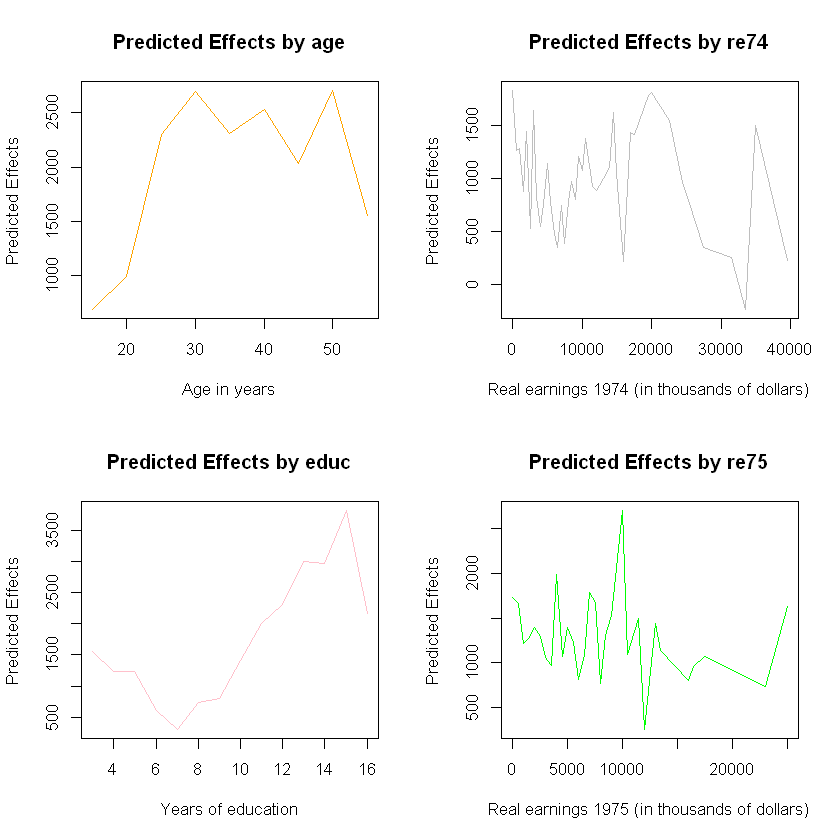

In [14]:
par(mfrow = c(2, 2))

# Predicted effects by age
plot(predicted_effects_age$age, predicted_effects_age$predicted_effects, type = "l", col = "orange",
     xlab = "Age in years", ylab = "Predicted Effects", main = "Predicted Effects by age")

# Predicted effects by re74
plot(predicted_effects_re74$re74, predicted_effects_re74$predicted_effects, type = "l", col = "gray",
     xlab = "Real earnings 1974 (in thousands of dollars)", ylab = "Predicted Effects", main = "Predicted Effects by re74")

# Predicted effects by educ
plot(predicted_effects_educ$educ, predicted_effects_educ$predicted_effects, type = "l", col = "pink",
     xlab = "Years of education", ylab = "Predicted Effects", main = "Predicted Effects by educ")

# Predicted effects by re75
plot(predicted_effects_re75$re75, predicted_effects_re75$predicted_effects, type = "l", col = "green",
     xlab = "Real earnings 1975 (in thousands of dollars)", ylab = "Predicted Effects", main = "Predicted Effects by re75")

In [ ]:
##PARTE 2: machine learning 
# cargar datos de NSW observacionales
# Cargar datos de NSW observacionales
url_obs_data <- "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/nsw74psid2.csv"
obs_data <- read.csv(url_obs_data)

# Visualizar los datos
head(obs_data)
*2.2 Comparación de grupos
# Resumen de estadísticas para tratamiento y control
obs_data %>% group_by(treat) %>% 
  summarise(
    mean_educ = mean(educ),
    mean_age = mean(age),
    mean_re75 = mean(re75)
  )
*2.3 Calcular el SMD
# Calcular el SMD (Simple Mean Difference)
treatment_group_obs <- obs_data %>% filter(treat == 1)
control_group_obs <- obs_data %>% filter(treat == 0)

SMD <- mean(treatment_group_obs$re78) - mean(control_group_obs$re78)
print(paste("El SMD es:", round(SMD, 2)))
*2.4 Usar el método DML
# Cargar librería para DML
library(DoubleML)

# Preparar datos para DML
dml_data <- DoubleMLData$new(data = obs_data, y_col = "re78", d_cols = "treat")

# Ajustar el modelo
set.seed(123)
learner <- lrn("regr.ranger")  # Random forest como predictor
dml_model <- DoubleMLPLR$new(data = dml_data, ml_g = learner, ml_m = learner)

# Entrenar el modelo
dml_model$fit()

# Estimar el ATE y el MSE
ATE_dml <- dml_model$coef
MSE <- dml_model$model_fit_stats
print(paste("ATE usando DML:", round(ATE_dml, 2)))
print(MSE)

: 